In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
np.random.seed(100)
import matplotlib as mlp
mlp.rcParams["legend.loc"] = 'upper right'
mlp.rcParams["legend.framealpha"] = 1
mlp.rcParams["legend.edgecolor"] = 'k'
mlp.rcParams["legend.fancybox"] = False
mlp.rcParams['font.size'] = 12
mlp.rcParams["legend.fontsize"] = 'small'
mlp.rcParams["axes.labelsize"] = 'large'

### 1. Запищем класс модели ошибок ИНС, который выдает теоретические значения и измерения

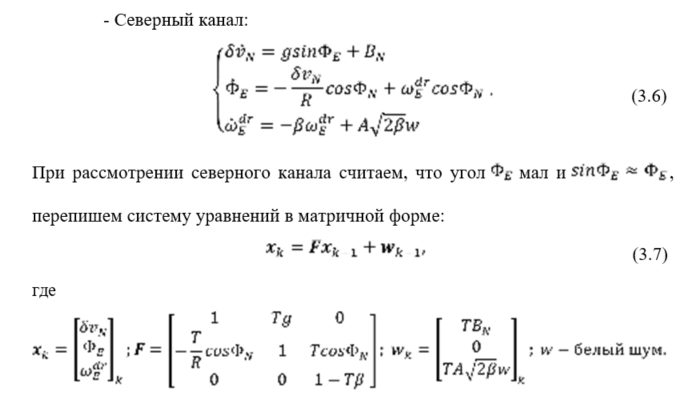
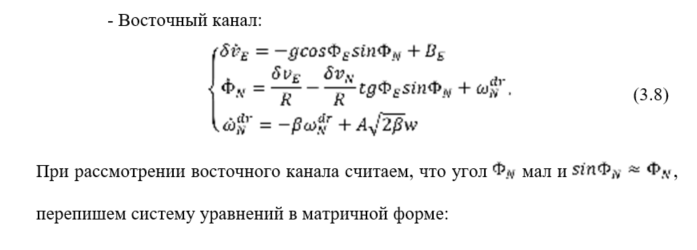
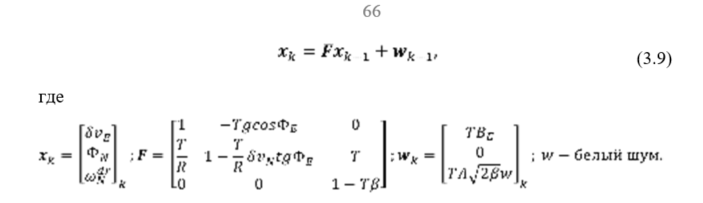

In [2]:
class NonlinearModel:
    def __init__(self, sigma=1e-8,  B=1e-4):
        # initial condition of parameters
        # T # период дискретизации 1 мин
        # g # ускорение свободного падения м/мин**2
        # b # cредняя частота случайного дрейфа м^-1
        # R # Радиус земли м
        self.T = 1
        self.g = 9.8*3600
        self.b = 0.02
        self.R = 6370000
        self.B = B
        self.sigma = sigma 
        
    def model(self, t, X):
        # Полные Д.У. 
        dX = np.zeros((6, 1))
        # северный канал
        dX[0,0] = self.g * np.sin(X[1]) + self.B
        dX[1,0] = -X[0]/self.R*np.cos(X[4]) + X[2]*np.cos(X[4])
        dX[2,0] = -self.b*X[2] + np.random.randn()*self.sigma*np.sqrt(2*self.b)
        
        # восточный
        dX[3,0] = -self.g * np.cos(X[1]) * np.sin(X[4]) + self.B
        dX[4,0] = X[3]/self.R - X[0]/self.R*np.tan(X[1])*np.sin(X[4]) + X[5]
        dX[5,0] = -X[5]*self.b + np.random.randn()*self.sigma*np.sqrt(2*self.b)
        return dX
        
    def get_theoretical_rk4(self, X, h, t):
        
        K1 = self.model(t, X[:,:1]);
        K2 = self.model(t + 1/2*h, X[:,:1] + 1/2*h*K1);
        K3 = self.model(t + 1/2*h, X[:,:1] + 1/2*h*K2);
        K4 = self.model(t + h, X[:,:1] + h*K3);
        return X[:,:1] + h/6*(K1 + 2*K2 + 2*K3 + K4);
    
    def get_theoretical_transfer_matrix(self, X):
        
        PHIe = X[1,0]
        PHIn = X[4,0]
        Vn = X[0,0]
        F = np.zeros((6, 6))

        Fe = np.array([[    1,               - self.g * self.T * np.cos(PHIe),           0           ],
                       [self.T/self.R,     1 - self.T/self.R * Vn * np.tan(PHIe),      self.T        ],
                       [    0,                               0,                        1-self.b*self.T]])
        
        Fn = np.array([[              1,                     self.g * self.T,             0            ],
                       [-self.T/self.R * np.cos(PHIn),             1,             self.T * np.cos(PHIn)],
                       [               0,                          0,              1-self.b*self.T     ]])
         
        W = np.array([[self.B], [0], [np.random.randn()*self.sigma*self.T*np.sqrt(2*self.b)],
                      [self.B], [0], [np.random.randn()*self.sigma*self.T*np.sqrt(2*self.b)]])
        
        F[:3, :3] = Fn
        F[3:, 3:] = Fe
        
        X = F @ X + W
        return X
    
    def get_measurements(self, X):
        Z = np.zeros((2,1))
        Z[0,0] = X[0,0] + np.random.randn(1)*0.5*60
        Z[1,0] = X[3,0] + np.random.randn(1)*0.5*60
        return Z

### 2. Запищем класс модели ошибок ИНС, который использует решение ode45

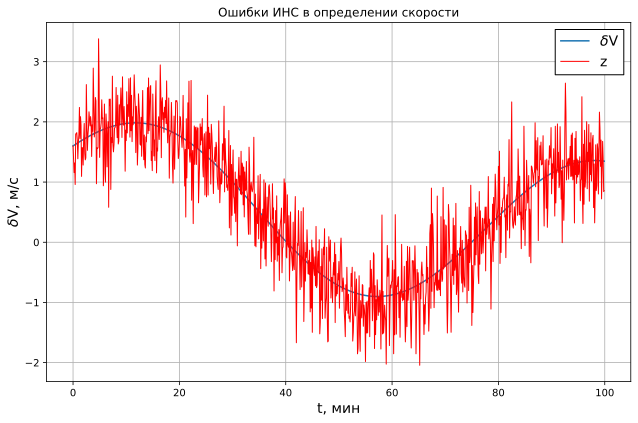

In [3]:
np.random.seed(42)
model = NonlinearModel()

X = np.array([[1.6*60,1e-4,1e-5,1.6*60,1e-4,1e-5]]).T
Z = np.array([[1.6*60],[1.6*60]])

# получение данных
t = np.arange(0,1000)
for i in range(len(t)-1):
#     X = np.concatenate((X, model.get_theoretical_transfer_matrix(X[:,-1:])), axis=1)
    X = np.concatenate((X, model.get_theoretical_rk4(X[:,-1:], 0.1, t[i])), axis=1)
    Z = np.concatenate((Z, model.get_measurements(X[:,-1:])), axis=1)
    

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(t/10, X[0,:]/60, label='$\delta$V')
ax.plot(t/10, Z[0,:]/60, lw=1, c='r', label='z')
ax.set_xlabel('t, мин', fontsize=14)
ax.set_ylabel('$\delta$V, м/с', fontsize=14)
ax.set_title('Ошибки ИНС в определении скорости')
plt.grid()
plt.legend(fontsize=14)
fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР_2\1.png', dpi=300,bbox_inches = 'tight')


### 3. Напишем НФК

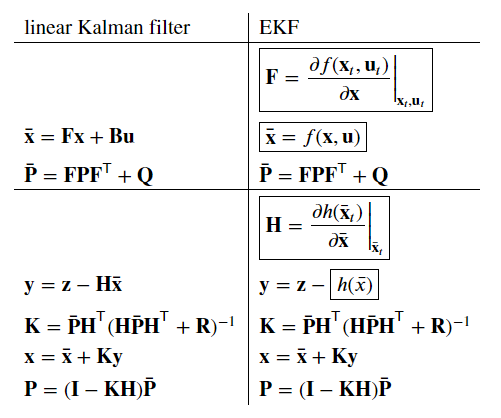

In [4]:
np.random.seed(42)
import scipy
class EKF:
    def __init__(self,P, Q, R, H):
        self.P_est = P[np.newaxis, :] #cov matrix state
        self.Q = Q #cov matrix process
        self.R1 = R #cov matrix measure
        self.H = H #matrix measure
        self.X_est = np.zeros((6,1))
        
        self.T = 1
        self.g = 9.8*3600
        self.b = 0.02
        self.R = 6370000
        self.B = 1e-4
        self.sigma = 1e-8 
        
        
    def model(self, t, X):
        # Полные Д.У. 
        dX = np.zeros((6, 1))
        # северный канал
        dX[0,0] = self.g * np.sin(X[1])
        dX[1,0] = -X[0]/self.R*np.cos(X[4]) + X[2]*np.cos(X[4])
        dX[2,0] = -self.b*X[2] 
        
        # восточный
        dX[3,0] = -self.g * np.cos(X[1]) * np.sin(X[4])
        dX[4,0] = X[3]/self.R - X[0]/self.R*np.tan(X[1])*np.sin(X[4]) + X[5]
        dX[5,0] = -X[5]*self.b
        return dX
        
    def get_X_rk4(self, X, h, t):
        
        K1 = self.model(t, X[:,:1])
        K2 = self.model(t + 1/2*h, X[:,:1] + 1/2*h*K1)
        K3 = self.model(t + 1/2*h, X[:,:1] + 1/2*h*K2)
        K4 = self.model(t + h, X[:,:1] + h*K3)
        return X[:,:1] + h/6*(K1 + 2*K2 + 2*K3 + K4)
    
    def get_P_rk4(self, F, P, Q, h):
        L = np.linalg.cholesky(P)
        P = L @ L.T
        def fnc(P,F,Q):
            return F@P + P@F.T + Q
        K1 = fnc(P, F, Q)
        K2 = fnc(P + 1/2*h*K1, F,Q)
        K3 = fnc(P + 1/2*h*K2, F,Q)
        K4 = fnc(P + h*K3, F,Q)
        return P + h/6*(K1 + 2*K2 + 2*K3 + K4)
    
    def Jacobian(self, X):
        F = np.array([[0, self.g*np.cos(X[1]), 0, 0, 0, 0],
                      [-1/self.R*np.cos(X[4]), 0, np.cos(X[4]), 0, X[0]/self.R*np.sin(X[4]) - X[2]*np.sin(X[4]), 0],
                      [0, 0, -self.b, 0, 0, 0],
                      [0, self.g*np.sin(X[4])*np.sin(X[1]), 0, 0, -self.g*np.cos(X[4])*np.cos(X[1]), 0],
                      [-1/self.R*np.tan(X[1])*np.sin(X[4]), -X[0]/self.R/(np.cos(X[1]))**2*np.sin(X[4]), 0, 1/self.R, 
                      -X[0]/self.R*np.tan(X[1])*np.cos(X[4]), 1],
                      [0, 0, 0, 0, 0, -self.b]])
#         F = np.zeros((6,6))
        return F
        
    def filtr(self, Z):
        
#         self.X_est = self.H.T @ Z[:,:1] 
#         self.X_est = np.array([[1.6*60,1e-4,1e-5,1.6*60,1e-4,1e-5]]).T
        self.X_est = np.zeros((6,1))

        for i in range(1, Z.shape[1]):
        
            PHIe = self.X_est[1,-1]
            PHIn = self.X_est[4,-1]
            Vn = self.X_est[0,-1]

            F = np.zeros((6, 6))

            Fe = np.array([[    1,               - self.g * self.T * np.cos(PHIe),           0           ],
                           [self.T/self.R,     1 - self.T/self.R * Vn * np.tan(PHIe),      self.T        ],
                           [    0,                               0,                        1-self.b*self.T]])

            Fn = np.array([[              1,                     self.g * self.T,             0            ],
                           [-self.T/self.R * np.cos(PHIn),             1,             self.T * np.cos(PHIn)],
                           [               0,                          0,              1-self.b*self.T     ]])

#             Fe = np.array([[ 1, - self.g * self.T, 0],
#                            [self.T/self.R, 1 ,  self.T],
#                            [ 0, 0,  1-self.b*self.T]])

#             Fn = np.array([[ 1,  self.g * self.T, 0],
#                            [-self.T/self.R, 1, self.T],
#                            [ 0,  0, 1-self.b*self.T ]])


            F[:3, :3] = Fn
            F[3:, 3:] = Fe
            #predict
#             X = F @ self.X_est[:,-1:]
            X = self.get_X_rk4(self.X_est[:,-1:], 0.1, 1)
#             for i in range(10):
#                 X = self.get_X_rk4(X, 0.001, 1)
            F = self.Jacobian(self.X_est[:,-1])
            P = self.get_P_rk4(F, self.P_est[-1], self.Q, 0.01)
            y = Z[:,i:i+1] - self.H @ X
#             P = F @ self.P_est[-1] @ F.T + self.Q

            #update
            K = P @ self.H.T @ np.linalg.inv(self.H @ P @ self.H.T + self.R1)
            self.X_est = np.hstack((self.X_est, X + K @ y))
#             self.X_est = np.hstack((self.X_est, X))
            I = np.eye(len(self.X_est))           
            self.P_est = np.vstack((self.P_est,(I - K @ self.H) @ P @ (I - K @ self.H).T + K @ self.R1 @ K.T[np.newaxis, :]))
            

        
        return self.X_est, self.P_est

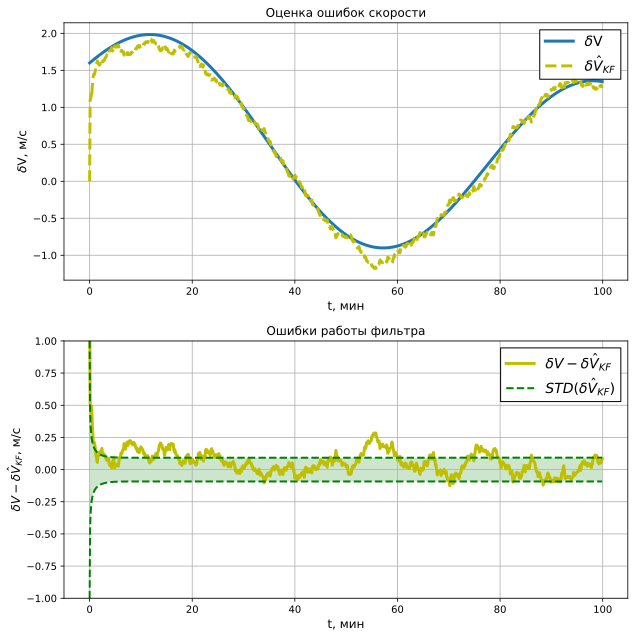

In [13]:
np.random.seed(42)
z_sco = 0.5*60
v0_sco = 1*60
phi0_sco = 1e-4
e0_sco = 1e-5
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2,v0_sco**2, phi0_sco**2, e0_sco**2])

Q = np.diag([1000, phi0_sco**2, e0_sco**2, 1000, phi0_sco**2, e0_sco**2])*0.1
# Q = np.diag([0,0,5e-13,0,0,5e-13])
R = np.diag([z_sco**2, z_sco**2])
H = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

KF = EKF(P, Q, R, H)
X_est, P_est, = KF.filtr(Z)

# fig, ax = plt.subplots(2,1, figsize=(12,9))
# ax[0].plot(t, X_est[0,:]/60,lw=3, label='$\delta$V')
# ax[0].plot(t, X[0,:]/60, label='$\delta$V')
# # ax[0].plot(t, Z[0,:]/60, '--', lw=1.5, c='r', label='z')
# ax[1].plot(np.sqrt(P_est[1:,0,0])/60)


fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t/10, X[0,:]/60,lw=3, label='$\delta$V')
# ax[0].plot(t, z/60, '--', lw=1.5, c='r', label='z')
ax[0].plot(t/10, X_est[0,:]/60, '--', lw=3, c='y', label='$\delta$$\hat{V}_{KF}$')
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Оценка ошибок скорости')
ax[0].grid()
ax[0].legend(fontsize=14)





ax[1].plot(t/10, (X[0,:] - X_est[0,:])/60, c='y',lw=3, label=r'$\delta{V}-\delta\hat{V}_{KF}$')
ax[1].plot(t/10, np.sqrt(P_est[:,0,0])/60, '--', lw=2, c='g',label=r'$STD(\delta{\hat{V}}_{KF})$')
ax[1].plot(t/10, -np.sqrt(P_est[:,0,0])/60, '--', lw=2, c='g')
ax[1].fill_between(t.ravel()/10, -np.sqrt(P_est[:,0,0])/60, np.sqrt(P_est[:,0,0])/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\delta{V}-\delta\hat{V}_{KF}$, м/с')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР_2\2.png', dpi=300,bbox_inches = 'tight')


In [11]:
t/10

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

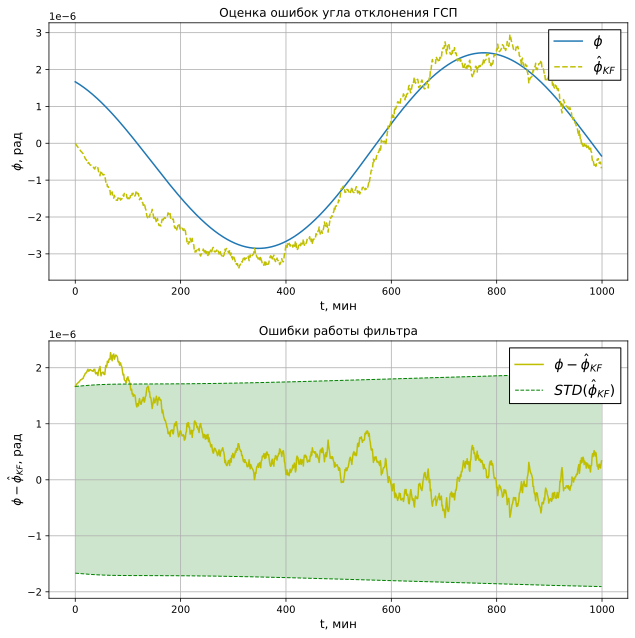

In [91]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, X[1,:]/60, lw=1.5, label='$\phi$')
ax[0].plot(t, X_est[1,:]/60, '--', lw=1.5, c='y', label='$\hat{\phi}_{KF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\phi$, рад')
ax[0].set_title('Оценка ошибок угла отклонения ГСП')
ax[0].grid()
ax[0].legend(fontsize=14)


ax[1].plot(t, (X[1,:]-X_est[1,:])/60, c='y', label=r'$\phi-\hat{\phi}_{KF}$')
ax[1].plot(t, np.sqrt(P_est[:,1,1])/60, '--', lw=1, c='g',label=r'$STD({\hat{\phi}}_{KF})$')
ax[1].plot(t, -np.sqrt(P_est[:,1,1])/60, '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_est[:,1,1])/60, np.sqrt(P_est[:,1,1])/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
# ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\phi-\hat{\phi}_{KF}$, рад')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР_2\3.png', dpi=300,bbox_inches = 'tight')

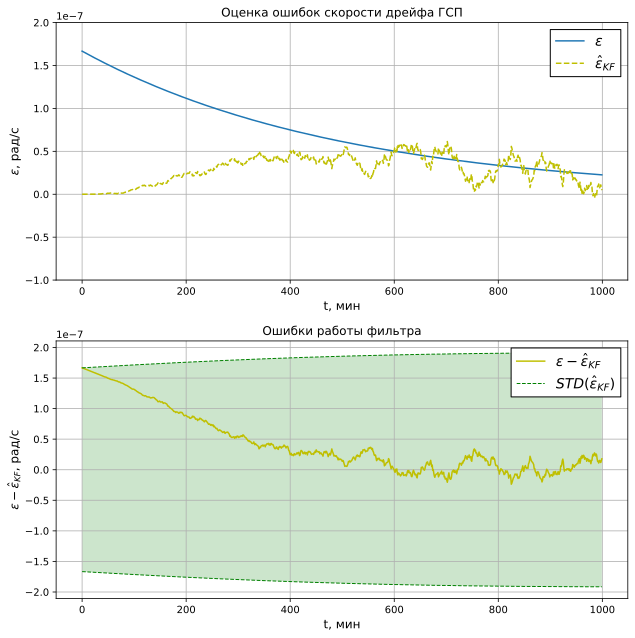

In [92]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, X[2,:]/60,lw=1.5, label='$\epsilon$')
ax[0].plot(t, X_est[2,:]/60, '--', lw=1.5, c='y', label='$\hat{\epsilon}_{KF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\epsilon$, рад/с')
ax[0].set_title('Оценка ошибок скорости дрейфа ГСП')
ax[0].set_ylim(-1e-7, 2e-7)
ax[0].grid()
ax[0].legend(fontsize=14)

ax[1].plot(t, (X[2,:]-X_est[2,:])/60,  lw=1.5, c='y', label='$\epsilon-\hat{\epsilon}_{KF}$')
ax[1].plot(t, np.sqrt(P_est[:,2,2])/60, '--', lw=1, c='g', label='$STD(\hat{\epsilon}_{KF})$')
ax[1].plot(t, -np.sqrt(P_est[:,2,2])/60, '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_est[:,2,2])/60, np.sqrt(P_est[:,2,2])/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\epsilon-\hat{\epsilon}_{KF}$, рад/с')

fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР_2\4.png', dpi=300,bbox_inches = 'tight')

### 4. Запишем UKF

(0.01933205582232549, 0.03603497115020018)

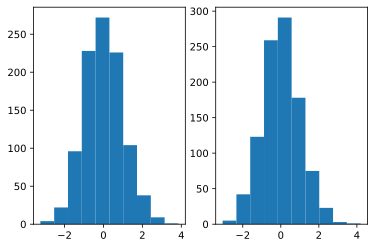

In [14]:
x = np.random.randn(6, 1000)
y = np.zeros((6, 1000))

for i in range(x.shape[1]):
    y[:,i:i+1] = KF.get_X_rk4(x[:,i:i+1], 0.00001, 1)
    
    
fig, ax = plt.subplots(1,2)
ax[0].hist(x[0,:])
ax[1].hist(y[0,:])

x[0,:].mean(), y[0,:].mean()

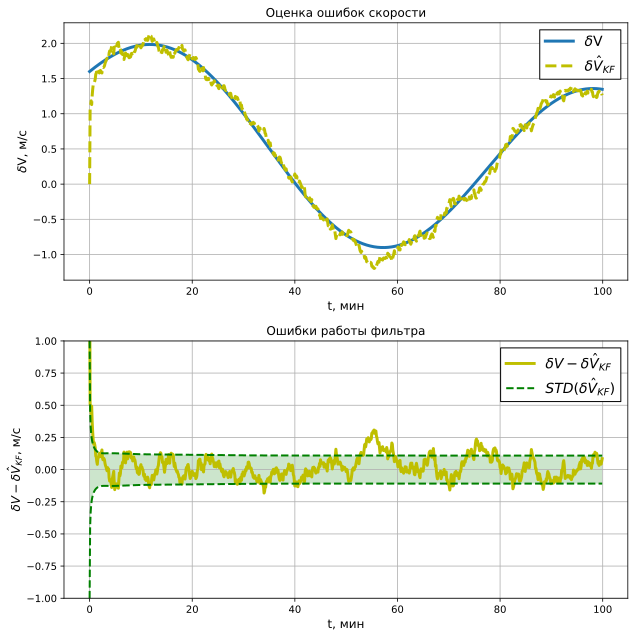

In [16]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import numpy as np
def fx(x, dt):
    
    T = 1
    g = 9.8*3600
    b = 0.02
    R = 6370000
    B = 1e-4
    sigma = 1e-8 
    
    def model(t, X):
 
        # Полные Д.У. 
        dX = np.zeros(6)
        # северный канал
        dX[0] = g * np.sin(X[1])
        dX[1] = -X[0]/R*np.cos(X[4]) + X[2]*np.cos(X[4])
        dX[2] = -b*X[2] 
        
        # восточный
        dX[3] = -g * np.cos(X[1]) * np.sin(X[4])
        dX[4] = X[3]/R - X[0]/R*np.tan(X[1])*np.sin(X[4]) + X[5]
        dX[5] = -X[5]*b
        return dX
        
    def get_X_rk4(X, h, t):
        
        K1 = model(t, X)
        K2 = model(t + 1/2*h, X+ 1/2*h*K1)
        K3 = model(t + 1/2*h, X + 1/2*h*K2)
        K4 = model(t + h, X + h*K3)
        return X + h/6*(K1 + 2*K2 + 2*K3 + K4)
    
    return get_X_rk4(x, dt, t)

def hx(x):
  # measurement function - convert state into a measurement
  # where measurements are [x_pos, y_pos]
    return np.array([x[0], x[3]])

dt = 0.1
# create sigma points to use in the filter. This is standard for Gaussian processes
points = MerweScaledSigmaPoints(6, alpha=0.1, beta=2, kappa=-1)
kf = UnscentedKalmanFilter(dim_x=6, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
kf.x = np.array([0, 0, 0, 0, 0, 0]) # initial state
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2,v0_sco**2, phi0_sco**2, e0_sco**2])
kf.P = P
z_std = 30
kf.R = np.diag([z_std**2, z_std**2]) # 1 standard
kf.Q = np.diag([1000, phi0_sco**2, e0_sco**2, 1000, phi0_sco**2, e0_sco**2])*0.001
zs = Z.T.tolist()
# zs = [[i+np.random.randn()*z_std, i+np.random.randn()*z_std] for i in range(140)] # measurements

X_est = np.zeros((6,1))
P_est = P[np.newaxis, :]
for i in range(1,len(zs)):
    kf.predict()
    kf.update(zs[i])
    X_est = np.concatenate((X_est, kf.x[:,np.newaxis]), axis=1)
    P_est = np.vstack((P_est, kf.P_post[np.newaxis, :]))

# #     print(kf.x, 'log-likelihood', kf.log_likelihood)


fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t/10, X[0,:]/60,lw=3, label='$\delta$V')
# ax[0].plot(t, z/60, '--', lw=1.5, c='r', label='z')
ax[0].plot(t/10, X_est[0,:]/60, '--', lw=3, c='y', label='$\delta$$\hat{V}_{KF}$')
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Оценка ошибок скорости')
ax[0].grid()
ax[0].legend(fontsize=14)





ax[1].plot(t/10, (X[0,:] - X_est[0,:])/60, c='y',lw=3, label=r'$\delta{V}-\delta\hat{V}_{KF}$')
ax[1].plot(t/10, np.sqrt(P_est[:,0,0])/60, '--', lw=2, c='g',label=r'$STD(\delta{\hat{V}}_{KF})$')
ax[1].plot(t/10, -np.sqrt(P_est[:,0,0])/60, '--', lw=2, c='g')
ax[1].fill_between(t.ravel()/10, -np.sqrt(P_est[:,0,0])/60, np.sqrt(P_est[:,0,0])/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\delta{V}-\delta\hat{V}_{KF}$, м/с')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР_2\5.png', dpi=300,bbox_inches = 'tight')

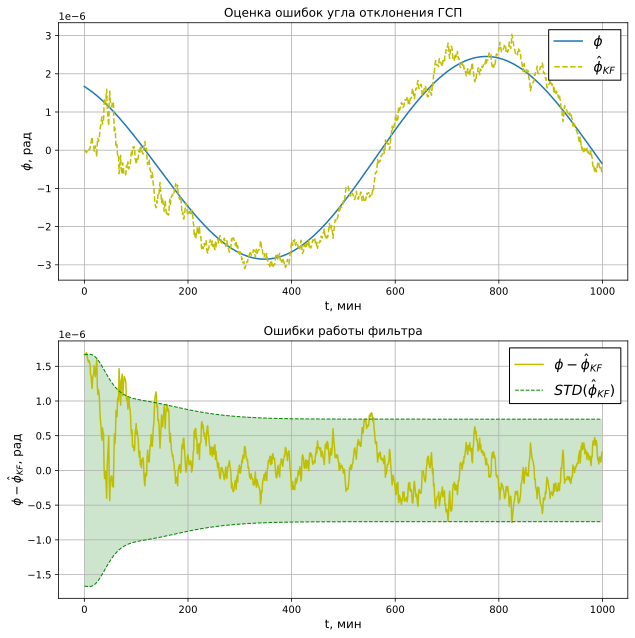

In [95]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, X[1,:]/60, lw=1.5, label='$\phi$')
ax[0].plot(t, X_est[1,:]/60, '--', lw=1.5, c='y', label='$\hat{\phi}_{KF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\phi$, рад')
ax[0].set_title('Оценка ошибок угла отклонения ГСП')
ax[0].grid()
ax[0].legend(fontsize=14)


ax[1].plot(t, (X[1,:]-X_est[1,:])/60, c='y', label=r'$\phi-\hat{\phi}_{KF}$')
ax[1].plot(t, np.sqrt(P_est[:,1,1])/60, '--', lw=1, c='g',label=r'$STD({\hat{\phi}}_{KF})$')
ax[1].plot(t, -np.sqrt(P_est[:,1,1])/60, '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_est[:,1,1])/60, np.sqrt(P_est[:,1,1])/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
# ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\phi-\hat{\phi}_{KF}$, рад')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР_2\9.png', dpi=300,bbox_inches = 'tight')

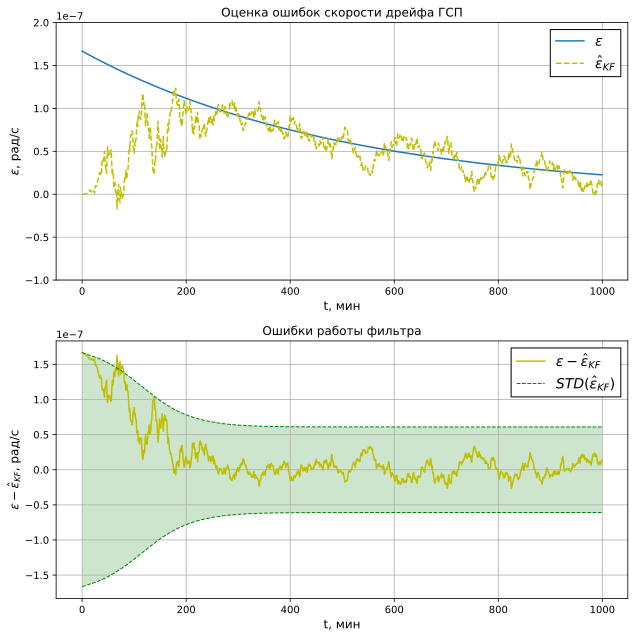

In [96]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, X[2,:]/60,lw=1.5, label='$\epsilon$')
ax[0].plot(t, X_est[2,:]/60, '--', lw=1.5, c='y', label='$\hat{\epsilon}_{KF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\epsilon$, рад/с')
ax[0].set_title('Оценка ошибок скорости дрейфа ГСП')
ax[0].set_ylim(-1e-7, 2e-7)
ax[0].grid()
ax[0].legend(fontsize=14)

ax[1].plot(t, (X[2,:]-X_est[2,:])/60,  lw=1.5, c='y', label='$\epsilon-\hat{\epsilon}_{KF}$')
ax[1].plot(t, np.sqrt(P_est[:,2,2])/60, '--', lw=1, c='g', label='$STD(\hat{\epsilon}_{KF})$')
ax[1].plot(t, -np.sqrt(P_est[:,2,2])/60, '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_est[:,2,2])/60, np.sqrt(P_est[:,2,2])/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\epsilon-\hat{\epsilon}_{KF}$, рад/с')

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР_2\10.png', dpi=300,bbox_inches = 'tight')